In [1]:
import os
from google.colab import drive
from google.colab import files
from IPython.display import Image
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLP Project')
os.getcwd()
!pip install tqdm
!pip install rank_bm25
!pip install ktrain
!pip install -U sentence-transformers
!pip install pot
!pip install GPUtil
!pip install pycurl
!pip install tensorflow_datasets
!pip install datasets

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 49.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 42.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 55.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 118.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 47.0 MB/s e

In [2]:
import nltk
import gensim
import ktrain
import torch
import os
import re
import pandas as pd
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from gensim.models import KeyedVectors
from gensim.similarities import WmdSimilarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
from rank_bm25 import BM25Okapi
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import DataLoader, Dataset, RandomSampler
from ktrain import text
from absl import logging

nltk.download('punkt')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
# uploaded = files.upload()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Utils

In [3]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    gc.collect()
    torch.cuda.empty_cache()

    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [4]:
def get_results(targets, preds):
  mse = mean_squared_error(targets, preds)
  rmse = mean_squared_error(targets, preds, squared=False)
  r2 = r2_score(targets, preds)

  print(f"MSE: {round(mse, 3)}")
  print(f"RMSE: {round(rmse, 3)}")
  print(f"R2: {round(r2, 3)}\n")

  return mse, rmse, r2

# Data Cleaning


Let us start with loading the data. There is alot of unformatted dirty data, therefore we have reformatted the different csv files to reduse the number of bad lines that we have to throw away. In some cases rows had to ble cleaned/deleted manually like in the case bellow:

![picture](https://drive.google.com/file/d/1FMUQGjeHGyI8AswHhvEs21jeNib9wiBn/view?usp=share_link)

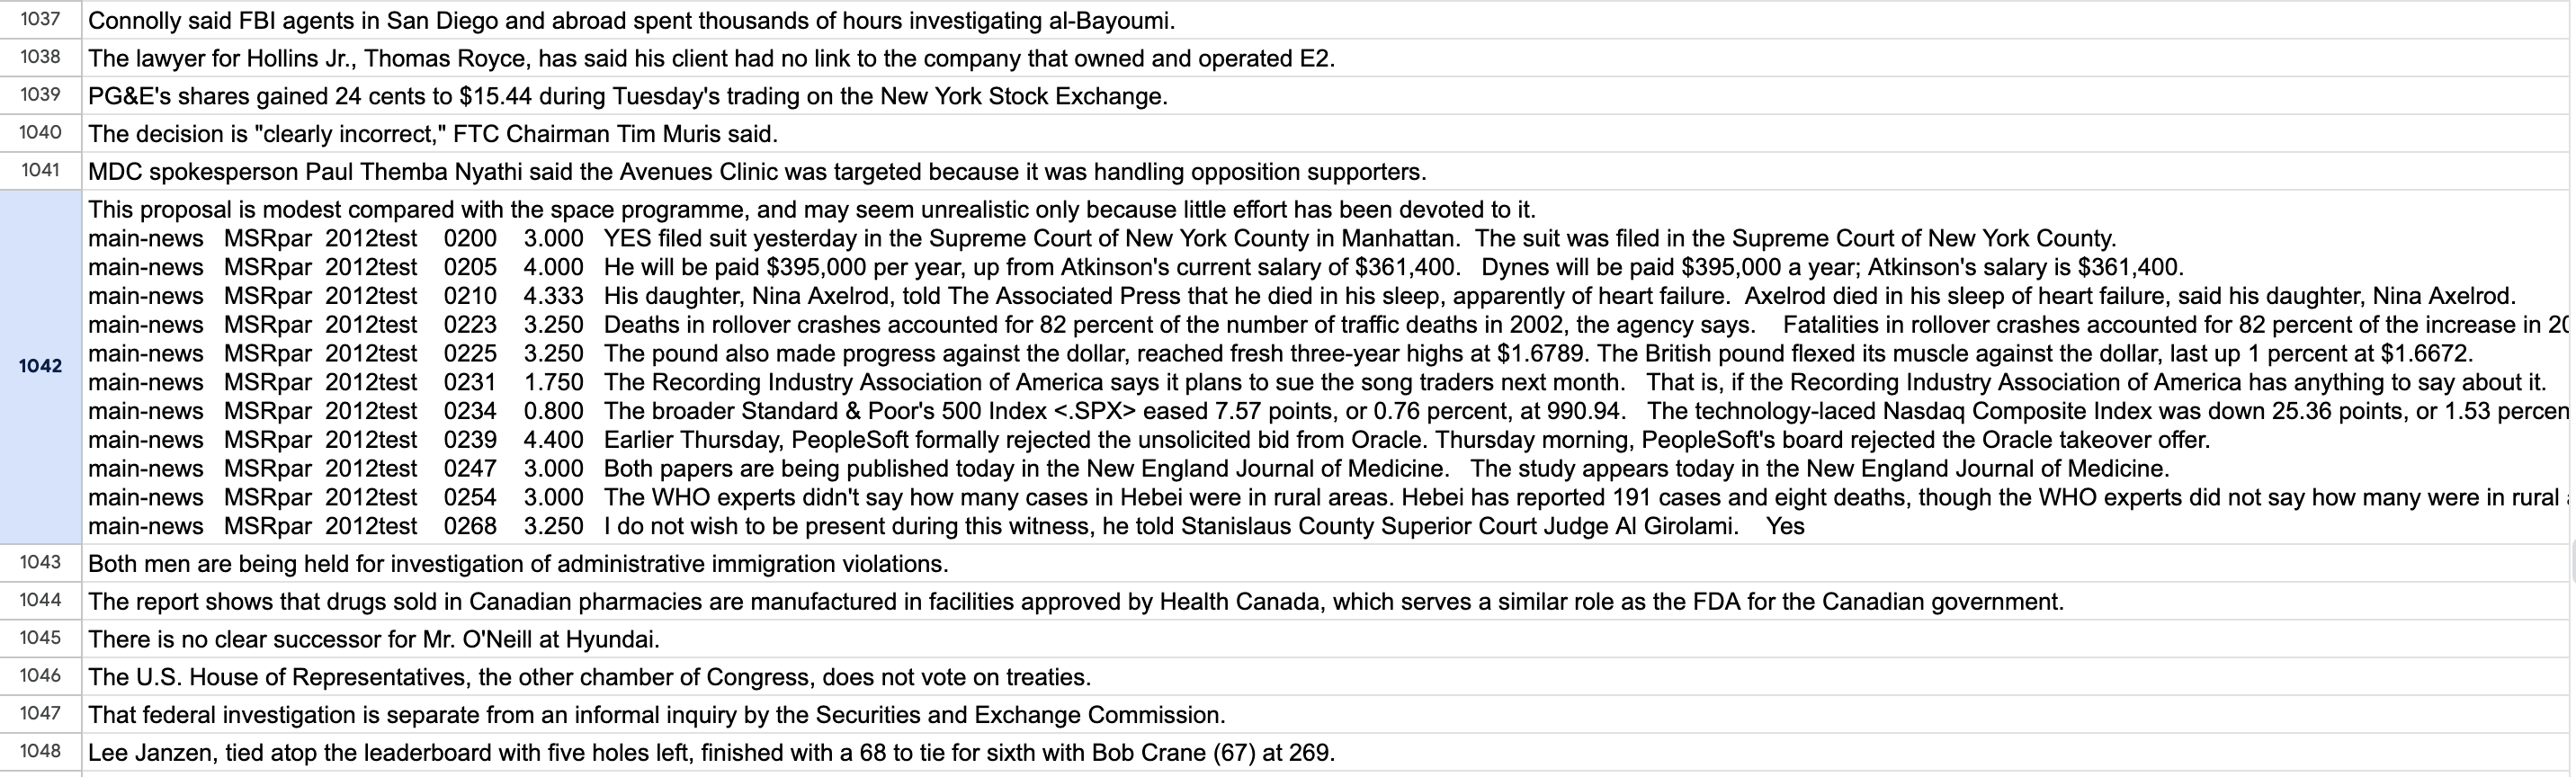

In [5]:
Image('dirty_data.png')

In other cases we could simply remove large unwanted columns of data:

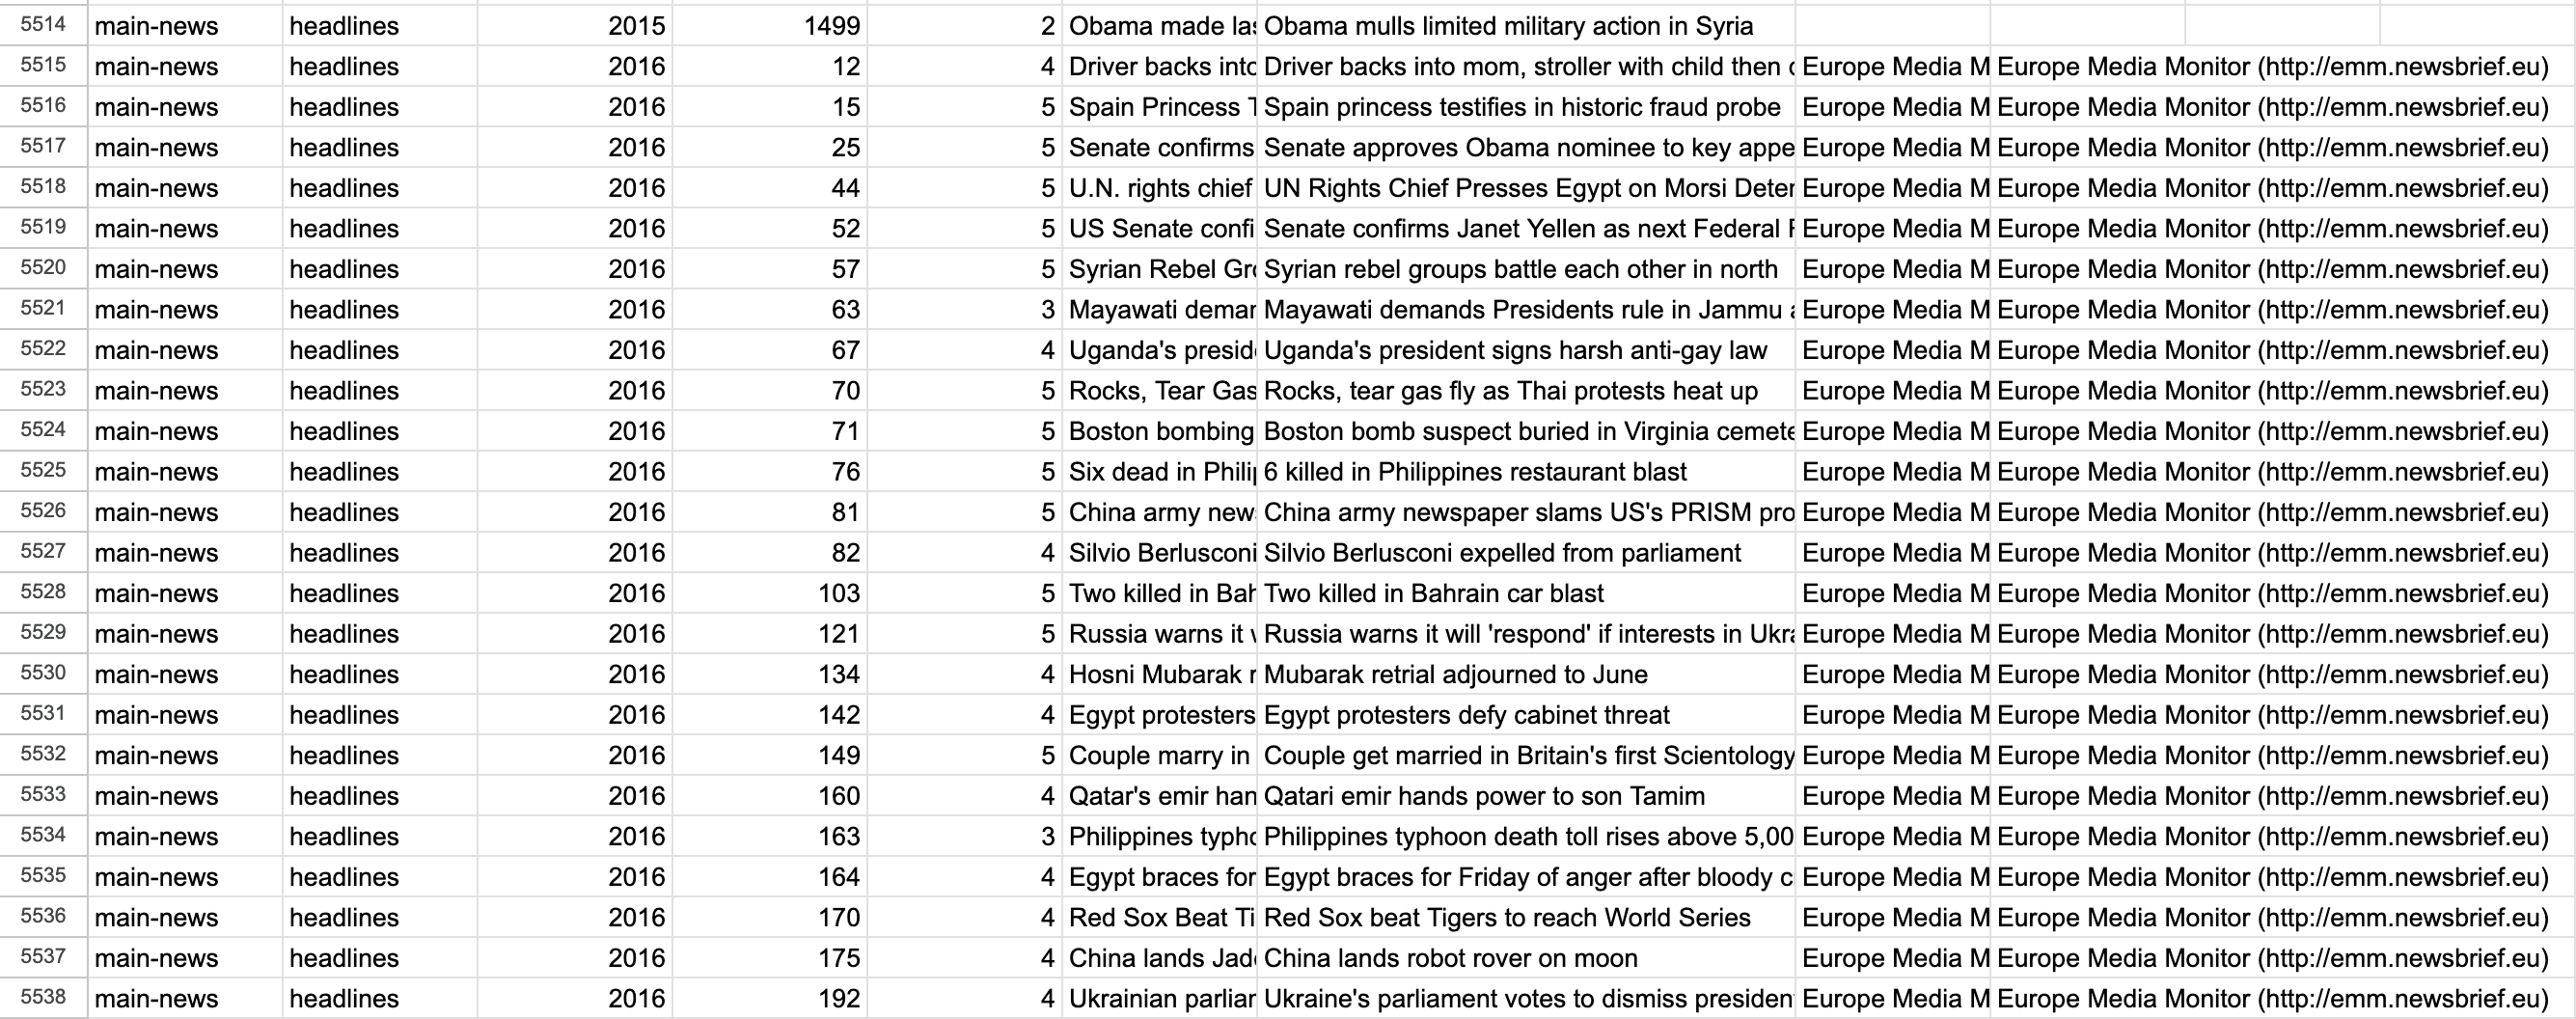

In [6]:
Image('dirty_col.png')

In [7]:
bad_lines_left = []
def bad_lines(row):
  print(len(row), row)
  bad_lines_left.append(row)

original_bad_lines = []
def all_bad_lines(row):
  original_bad_lines.append(row)

columns = ['genre', 'file', 'years', 'id', 'score', 'sentence1', 'sentence2']

train = pd.read_csv('data/sts-train-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_train = pd.read_csv('data/original/sts-train.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'train rows: {len(train)}')
print(f'difference in number of lines: {len(train)-len(dirty_train)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(train[train.isnull().any(axis=1)]), '\n')
train = train.dropna()
bad_lines_left, original_bad_lines = [], []

dev = pd.read_csv('data/sts-dev-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_dev = pd.read_csv('data/original/sts-dev.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'dev rows: {len(dev)}')
print(f'difference in number of lines: {len(dev)-len(dirty_dev)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(dev[dev.isnull().any(axis=1)]), '\n')
dev = dev.dropna()
bad_lines_left, original_bad_lines = [], []

test = pd.read_csv('data/sts-test-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_test = pd.read_csv('data/original/sts-test.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'test rows: {len(test)}')
print(f'difference in number of lines: {len(test)-len(dirty_test)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'test with nan:', len(test[test.isnull().any(axis=1)]), '\n')
test = test.dropna()
bad_lines_left, original_bad_lines = [], []

train.head(50)

train rows: 5749
difference in number of lines: 1571
bad lines left: 0
lines with nan: 0 

dev rows: 1500
difference in number of lines: 537
bad lines left: 0
lines with nan: 0 

test rows: 1379
difference in number of lines: 347
bad lines left: 0
test with nan: 0 



,genre,file,years,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1.0,5.000,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4.0,3.800,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5.0,3.800,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6.0,2.600,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9.0,4.250,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...,...,...,...,...
45,main-captions,MSRvid,2012test,68.0,1.000,A man is playing the piano.,A woman is playing the violin.
46,main-captions,MSRvid,2012test,69.0,1.000,A woman is playing the flute.,A man is playing the guitar.
47,main-captions,MSRvid,2012test,70.0,2.375,A man is cutting up a potato.,A man is cutting up carrots.
48,main-captions,MSRvid,2012test,71.0,3.800,A kid is playing guitar.,A boy is playing a guitar.


# Additional datasets
This dataset is from: https://huggingface.co/datasets/sem_eval_2014_task_1

In [8]:
train_json = !curl -X GET "https://datasets-server.huggingface.co/rows?dataset=sem_eval_2014_task_1&config=default&split=train&offset=0&limit=100"
ds = tfds.load('huggingface:sem_eval_2014_task_1')
tfds_frame = tfds.as_dataframe(ds['validation'])
os.chdir('/content/drive/MyDrive/NLP Project/data/additional_datasets/')
os.getcwd()
tfds_frame.to_csv("sem_eval_2014_val.csv")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4927 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset sem_eval_2014_task_1 downloaded and prepared to /root/.cache/huggingface/datasets/sem_eval_2014_task_1/default/1.0.0/05e094e84ece42e036799e05c4d909ee68f6df8f82f60f9302b8ef15bb9de478. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/sem_eval_2014_task_1/1.0.0.incompleteEEG55H/sem_eval_2014_task_1-train.tfr…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/sem_eval_2014_task_1/1.0.0.incompleteEEG55H/sem_eval_2014_task_1-test.tfre…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/sem_eval_2014_task_1/1.0.0.incompleteEEG55H/sem_eval_2014_task_1-validatio…

Dataset sem_eval_2014_task_1 downloaded and prepared to /root/tensorflow_datasets/sem_eval_2014_task_1/1.0.0. Subsequent calls will reuse this data.


In [9]:
files = ["sem_eval_2014_train.csv", "sem_eval_2014_test.csv", "sem_eval_2014_val.csv"]
sem_eval_2014_dataset_df = pd.DataFrame()
for file in files:
  df = pd.read_csv(file, header = 0, sep=",", names=['NA1','NA2','sentence1', 'sentence2', 'score', 'NA3'])
  sem_eval_2014_dataset_df = pd.concat([sem_eval_2014_dataset_df, df])

# Convert the score to a float
sem_eval_2014_dataset_df['score'] = sem_eval_2014_dataset_df['score'].astype(float)

# Slice the b''. (It is not a b-string)
sem_eval_2014_dataset_df['sentence1'] = sem_eval_2014_dataset_df['sentence1'].str.slice(2,-1)
sem_eval_2014_dataset_df['sentence2'] = sem_eval_2014_dataset_df['sentence2'].str.slice(2,-1)
sem_eval_2014_dataset_df = sem_eval_2014_dataset_df.reset_index()[['sentence1', 'sentence2', 'score']].dropna()

os.chdir('/content/drive/MyDrive/NLP Project')
sem_eval_2014_dataset_df.head(5)

,sentence1,sentence2,score
0,A man is playing a guitar,A man is throwing away a guitar,3.0
1,A woman is cooking a breaded pork chop,The woman is frying a breaded pork chop,4.7
2,The man dressed in leather chaps and a purple ...,The man dressed in chaps made of leather and a...,4.4
3,A grey dog is bouncing a tennis ball on its he...,A grey dog is bouncing a soccer ball on its he...,3.9
4,Two young women with folded arms are looking a...,Two women with black hair are standing in fron...,2.0


In [10]:
train = pd.concat([train, sem_eval_2014_dataset_df]) # Additional dataset

In [11]:
df_train = train[['sentence1', 'sentence2', 'score']].copy()
df_test = dev[['sentence1', 'sentence2', 'score']].copy()

df_train['score'] = df_train['score'].astype(float)
df_test['score'] = df_test['score'].astype(float)

test_results = dev.copy()
train_results = train.copy()

test_targets = df_test['score'].values
train_targets = df_train['score'].values

In [12]:
# Extract values of sentence1 and sentence2 into separate 1D lists
train_sentence1 = df_train['sentence1'].tolist()
train_sentence2 = df_train['sentence2'].tolist()
train_sentences = train_sentence1 + train_sentence2

test_sentence1 = df_test['sentence1'].tolist()
test_sentence2 = df_test['sentence2'].tolist()
test_sentences = test_sentence1 + test_sentence2

# TF-IDF similarity

In [13]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

Let's have a quick look at the vocabulary. How big is it?

In [14]:
# Fit and transform the vectorizer to the sentences
train_vectors = vectorizer.fit_transform(train_sentences)
train_vocab = vectorizer.get_feature_names_out()

test_vectors = vectorizer.fit_transform(test_sentences)
test_vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary train: {len(train_vocab)}\n")
print(f"Length of vocabulary test: {len(test_vocab)}\n")

Length of vocabulary train: 3936

Length of vocabulary test: 854

000


The decimial values are the TF-IDF scores for the terms. We can sort the terms of the first document by its TF-IDF values, and print them out as follows:

In [15]:
print(sorted([(test_vocab[j], test_vectors[0, j]) for j in test_vectors[0].nonzero()[1]], key=lambda x: -x[1]))
print(test_sentences[0])

[('hat', 0.5766879000487317), ('hard', 0.5621106714981192), ('dancing', 0.520262868663519), ('man', 0.2842344215877511)]
A man with a hard hat is dancing.


In [16]:
test_vectors[0].multiply(test_vectors[len(test_sentence1)]).sum() * 5

4.401913919874643

The dot-product between vectors computes the cosine of the angle between them. 
- The cosine of the angle between tf-idf vectors provides a value in the range [0,1], that is often used to measure the similarity between documents.
- Let's compute the similarity between the sentence1 and sentence2 and scale the result by  5 to get the appropriate proportion to the similiarity score.

In [17]:
train_tf_idf_similarity = []
for i in range(len(train_sentence1)):
    train_tf_idf_similarity.append(train_vectors[i].multiply(train_vectors[i+len(train_sentence1)]).sum()*5)

test_tf_idf_similarity = []
for i in range(len(test_sentence1)):
    test_tf_idf_similarity.append(test_vectors[i].multiply(test_vectors[i+len(test_sentence1)]).sum()*5)

train_results['tf-idf_score'] = train_tf_idf_similarity
test_results['tf-idf_score'] = test_tf_idf_similarity

get_results(train_targets, train_tf_idf_similarity)
get_results(test_targets, test_tf_idf_similarity)

test_results.head(5)

MSE: 2.258
RMSE: 1.503
R2: -0.412

MSE: 2.046
RMSE: 1.43
R2: 0.091



,genre,file,years,id,score,sentence1,sentence2,tf-idf_score
0,main-captions,MSRvid,2012test,0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,4.401914
1,main-captions,MSRvid,2012test,2,4.75,A young child is riding a horse.,A child is riding a horse.,4.377900
2,main-captions,MSRvid,2012test,3,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.000000
3,main-captions,MSRvid,2012test,7,2.40,A woman is playing the guitar.,A man is playing guitar.,3.908029
4,main-captions,MSRvid,2012test,8,2.75,A woman is playing the flute.,A man is playing a flute.,4.130933


# BM25

In [18]:
def bm25(df, sentences, vocab, targets, results):
  sentence1 = df['sentence1'].tolist()
  sentence2 = df['sentence2'].tolist()

  preprocessed_docs = [doc.lower().split() for doc in sentences]

  filtered_docs = []
  for doc in preprocessed_docs:
    filtered_docs.append([word for word in doc if word in vocab])
  
  bm25 = BM25Okapi(filtered_docs)

  bm25_similarity = []
  for doc1, doc2 in zip(sentence1, sentence2):
    score1, score2 = bm25.get_scores(doc1.split(" ")), bm25.get_scores(doc2.split(" "))
    bm25_similarity.append(round(cosine_similarity(score1.reshape(1, -1), score2.reshape(1, -1))[0][0]*5, 4))

  get_results(targets, bm25_similarity)
  results['bm25_score'] = bm25_similarity


print('Train bm25 score:')
bm25(df_train, train_sentences, train_vocab, train_targets, train_results)
print('Test bm25 score:')
bm25(df_test, test_sentences, test_vocab, test_targets, test_results)

Train bm25 score:
MSE: 2.403
RMSE: 1.55
R2: -0.502

Test bm25 score:
MSE: 3.935
RMSE: 1.984
R2: -0.749



# BOW n-gram similarity

In [19]:
def get_bow_bi_tri_similarity(sent1, sent2):
  # create count vectorizer
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
  vectorizer.fit_transform([sent1, sent2])

  # create bag of words vectors for each sentence
  vec1, vec2 = vectorizer.transform([sent1]), vectorizer.transform([sent2])

  # compute cosine similarity between vectors
  similarity = cosine_similarity(vec1, vec2)
  return (similarity[0][0]*5, vectorizer)

similarity, vectorizer = get_bow_bi_tri_similarity('A plane is taking off.', 'An air plane is taking off.')
vectorizer.get_feature_names_out()

array(['air', 'air plane', 'air plane is', 'an', 'an air', 'an air plane',
       'is', 'is taking', 'is taking off', 'off', 'plane', 'plane is',
       'plane is taking', 'taking', 'taking off'], dtype=object)

In [20]:
train_bow_bi_tri_similarity = []
for _, (sentence1, sentence2, _) in df_train.iterrows():
    train_bow_bi_tri_similarity.append(get_bow_bi_tri_similarity(sentence1, sentence2)[0])

test_bow_bi_tri_similarity = []
for _, (sentence1, sentence2, _) in df_test.iterrows():
    test_bow_bi_tri_similarity.append(get_bow_bi_tri_similarity(sentence1, sentence2)[0])

In [21]:
get_results(train_targets, train_bow_bi_tri_similarity)
train_results['bow_score'] = train_bow_bi_tri_similarity

get_results(train_targets, test_bow_bi_tri_similarity)
test_results['bow_score'] = test_bow_bi_tri_similarity
test_results.head(5)

,genre,file,years,id,...,sentence2,tf-idf_score,bm25_score,bow_score
0,main-captions,MSRvid,2012test,0,...,A man wearing a hard hat is dancing.,4.401914,4.7638,3.333333
1,main-captions,MSRvid,2012test,2,...,A child is riding a horse.,4.377900,4.2875,4.330127
2,main-captions,MSRvid,2012test,3,...,The man is feeding a mouse to the snake.,5.000000,5.0000,3.499482
3,main-captions,MSRvid,2012test,7,...,A man is playing guitar.,3.908029,2.8089,1.924501
4,main-captions,MSRvid,2012test,8,...,A man is playing a flute.,4.130933,2.8089,1.924501


# Average word embeddings

In [22]:
# Load pre-trained Word2Vec model
model_twitter = api.load("glove-twitter-50")
model_wiki = api.load("glove-wiki-gigaword-50")
fasttext_wiki = api.load("fasttext-wiki-news-subwords-300")
embeddings = [(model_twitter, 'glove-twitter-50'), (model_wiki, 'glove-wiki-gigaword-50'), (fasttext_wiki, 'fasttext-wiki-news-subwords-300')]

[==================================================] 100.0% 199.5/199.5MB downloaded
[==================================================] 100.0% 66.0/66.0MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [23]:
def avg_embedding_sentence_similarity(sent1, sent2, model):
    # Tokenize the sentences
    sent1_tokens = nltk.word_tokenize(sent1.lower())
    sent2_tokens = nltk.word_tokenize(sent2.lower())
    
    # Compute the average embedding for each sentence
    sent1_embedding = np.mean([model.get_vector(word) for word in sent1_tokens if word in model.key_to_index], axis=0)
    sent2_embedding = np.mean([model.get_vector(word) for word in sent2_tokens if word in model.key_to_index], axis=0)
    
    # Compute the cosine similarity between the two embeddings
    similarity = cosine_similarity([sent1_embedding], [sent2_embedding])[0][0]*5
    
    return similarity


In [24]:
def best_embedding(df, targets):
  best_mse = float('inf')
  best_avg_embeddings_similarity = []
  embedding_name = ''
  for embedding in embeddings:
    avg_embeddings_similarity = []
    for _, (sentence1, sentence2, _) in df.iterrows():
        avg_embeddings_similarity.append(avg_embedding_sentence_similarity(sentence1, sentence2, embedding[0]))

    print('Embedding:', embedding[1])
    mse, rmse, r2 = get_results(targets, avg_embeddings_similarity)
    if mse < best_mse:
      best_mse = mse
      best_avg_embeddings_similarity = avg_embeddings_similarity
      embedding_name = embedding[1]
  return best_avg_embeddings_similarity

print('Train:')
train_avg_embeddings_similarity = best_embedding(df_train, train_targets)

print('Test:')
test_avg_embeddings_similarity = best_embedding(df_test, test_targets)

train_results['avg_embeddings_score'] = train_avg_embeddings_similarity
test_results['avg_embeddings_score'] = test_avg_embeddings_similarity

test_results.head(5)

Train:
Embedding: glove-twitter-50
MSE: 4.047
RMSE: 2.012
R2: -1.53

Embedding: glove-wiki-gigaword-50
MSE: 3.816
RMSE: 1.953
R2: -1.386

Embedding: fasttext-wiki-news-subwords-300
MSE: 3.093
RMSE: 1.759
R2: -0.934

Test:
Embedding: glove-twitter-50
MSE: 8.084
RMSE: 2.843
R2: -2.593

Embedding: glove-wiki-gigaword-50
MSE: 7.771
RMSE: 2.788
R2: -2.454

Embedding: fasttext-wiki-news-subwords-300
MSE: 6.307
RMSE: 2.511
R2: -1.803



,genre,file,years,id,...,tf-idf_score,bm25_score,bow_score,avg_embeddings_score
0,main-captions,MSRvid,2012test,0,...,4.401914,4.7638,3.333333,4.950282
1,main-captions,MSRvid,2012test,2,...,4.377900,4.2875,4.330127,4.947909
2,main-captions,MSRvid,2012test,3,...,5.000000,5.0000,3.499482,4.321450
3,main-captions,MSRvid,2012test,7,...,3.908029,2.8089,1.924501,4.884584
4,main-captions,MSRvid,2012test,8,...,4.130933,2.8089,1.924501,4.725387


# Doc2Vec

In [25]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def doc2vec(sentences1, sentences2, targets, results):
  tokenized_sentences = [nltk.word_tokenize(sentence.lower()) for sentence in sentences1 + sentences2]
  tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sentences)]
  model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

  doc2vec_similarity = []
  for sentence1, sentence2 in zip(sentences1, sentences2):
    vector_1 = model.infer_vector(nltk.word_tokenize(sentence1.lower()))
    vector_2 = model.infer_vector(nltk.word_tokenize(sentence2.lower()))
    doc2vec_similarity.append(cosine_similarity(vector_1.reshape(1, -1), vector_2.reshape(1, -1))[0][0] * 5)

  get_results(targets, doc2vec_similarity)
  results['doc2vec_score'] = doc2vec_similarity

doc2vec(train_sentence1, train_sentence2, train_targets, train_results)
doc2vec(test_sentence1, test_sentence2, test_targets, test_results)

MSE: 1.616
RMSE: 1.271
R2: -0.01

MSE: 2.377
RMSE: 1.542
R2: -0.057



#Word Mover's Distance (WMD) 

is a method used to measure the semantic similarity between two sentences. It takes into account the distance between word embeddings in a vector space.

In [26]:
word_vectors = fasttext_wiki

def wmd(sentences1, sentences2, targets, results):
  wmd_similarity = []
  for sentence1, sentence2 in zip(sentences1, sentences2):
    sent1_tokens = nltk.word_tokenize(sentence1.lower())
    sent2_tokens = nltk.word_tokenize(sentence2.lower())
    instance = WmdSimilarity([sent1_tokens], word_vectors)
    similarity = instance.get_similarities([sent2_tokens])[0]
    wmd_similarity.append(similarity)

  get_results(targets, wmd_similarity)
  results['wmd_score'] = wmd_similarity


wmd(train_sentence1, train_sentence2, train_targets, train_results)
wmd(test_sentence1, test_sentence2, test_targets, test_results)

MSE: 7.808
RMSE: 2.794
R2: -3.881

MSE: 5.019
RMSE: 2.24
R2: -1.231



# Universal Sentence Encoder


The Universal Sentence Encoder (USE) is a natural language processing (NLP) model developed by Google that converts sentences or short texts into fixed-length vector representations, also known as embeddings. These embeddings capture the semantic meaning of the sentences and enable various downstream tasks, such as text classification, clustering, semantic similarity calculation, and more. The USE model is based on deep learning techniques, specifically using a variation of the Transformer architecture. 

In [27]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

logging.set_verbosity(logging.ERROR)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [28]:
def use(sentence1, sentence2, targets, results):
  embeddings1 = model(sentence1)
  embeddings2 = model(sentence2)
  use_similarity = np.diagonal(cosine_similarity(embeddings1, embeddings2))
  use_similarity = [0 if score < 0 else score * 5 for score in use_similarity] # Sentences that are opposing should just be zero
  get_results(targets, use_similarity)
  results['use_score'] = use_similarity

use(train_sentence1, train_sentence2, train_targets, train_results)
use(test_sentence1, test_sentence2, test_targets, test_results)

MSE: 0.761
RMSE: 0.872
R2: 0.524

MSE: 0.96
RMSE: 0.98
R2: 0.573



# InferSent

InferSent is a sentence embeddings method that utilizes a bi-directional LSTM (Long Short-Term Memory) network to encode sentences into fixed-length vectors. It is trained on various natural language understanding tasks, enabling it to capture sentence semantics and infer similarity.

https://github.com/facebookresearch/InferSent?fbclid=IwAR0j7JJDc4HiTtg1fKMVjDMYDFw7EqALWWygDsAGiRVeSGQ6oednJfUozHc

In [36]:
# !git clone https://github.com/facebookresearch/InferSent.git
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove.840B.300d.zip
%cd InferSent
from models import InferSent
%cd ..

/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project


In [37]:
model_version = 1
MODEL_PATH = 'encoder/infersent%s.pkl' % model_version
W2V_PATH = 'glove.840B.300d.txt'
VOCAB_SIZE = 1e4  # Load embeddings of VOCAB_SIZE most frequent words
USE_CUDA = False  # Keep it on CPU if False, otherwise will put it on GPU

In [38]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [39]:
model = model.cuda() if USE_CUDA else model
model.set_w2v_path(W2V_PATH)
# model.build_vocab_k_words(K=VOCAB_SIZE)

In [40]:
def infersent(sentences1, sentences2, targets, results):
  model.build_vocab(sentences1 + sentences2, tokenize=True)

  embeddings1 = model.encode(sentences1, tokenize=True, verbose=False) # bsize=128
  embeddings2 = model.encode(sentences2, tokenize=True, verbose=False) # bsize=128

  infersent_sim = np.diagonal(cosine_similarity(embeddings1, embeddings2))
  get_results(targets, infersent_sim)
  results['inferSent_score'] = infersent_sim

infersent(train_sentence1, train_sentence2, train_targets, train_results)
infersent(test_sentence1, test_sentence2, test_targets, test_results)

Found 14503(/15166) words with w2v vectors
Vocab size : 14503


/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


MSE: 7.296
RMSE: 2.701
R2: -3.561

Found 7021(/7192) words with w2v vectors
Vocab size : 7021


/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


MSE: 4.512
RMSE: 2.124
R2: -1.005



# Siamese Network LSTM

In [41]:
import keras
import keras.backend as K
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import ZeroPadding2D, Activation, Input, concatenate, Embedding, LSTM, GRU
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

In [42]:
vocab_size = 400
max_length = 15    # Max length of input sentences
tf.keras.utils.set_random_seed(1)

tok = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tok.fit_on_texts(train_sentences + test_sentences)

# Padding sequences to a max embedding length of 100 dim and max len of the sequence to 300
train_q1_seq = tok.texts_to_sequences(train_sentence1)
train_q2_seq = tok.texts_to_sequences(train_sentence2)

val_q1_seq = tok.texts_to_sequences(test_sentence1)
val_q2_seq = tok.texts_to_sequences(test_sentence2)


train_q1_seq = tf.keras.utils.pad_sequences(train_q1_seq, maxlen=max_length, padding='post')
train_q2_seq = tf.keras.utils.pad_sequences(train_q2_seq, maxlen=max_length, padding='post')

val_q1_seq = tf.keras.utils.pad_sequences(val_q1_seq, maxlen=max_length, padding='post')
val_q2_seq = tf.keras.utils.pad_sequences(val_q2_seq, maxlen=max_length, padding='post')

print(train_q1_seq[0], train_q2_seq[0], train_targets[0])

[  2 339   3 160  92   0   0   0   0   0   0   0   0   0   0] [ 19  98 339   3 160  92   0   0   0   0   0   0   0   0   0] 5.0


In [43]:
# parameters
embed_size = 400    # Size of word embeddings
units = 3

# define base network for siamese model
def create_base_network():
    input = Input(shape=(max_length,), dtype='int32')
    x = Embedding(vocab_size, embed_size, input_length=max_length)(input)
    x = keras.layers.LSTM(units, kernel_regularizer=l2(0.01))(x)  # add L2 regularization
    # x = keras.layers.Dropout(0.5)(x) 
    return Model(inputs=input, outputs=x)

# siamese model
base_network = create_base_network()

input_a = Input(shape=(max_length,))
input_b = Input(shape=(max_length,))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# calculate euclidean distance
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([processed_a, processed_b])
similarity_score = Dense(1, activation='sigmoid')(L1_distance)
scaled_similarity_score = Lambda(lambda x: x * 5)(similarity_score)  # scale the output to the range 0-5

model = Model(inputs=[input_a, input_b], outputs=scaled_similarity_score)

# compile model
optimizer = Adam(lr=0.001)  # gradient clipping to avoid exploding gradients
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

# print model summary
# model.summary()
model.fit([train_q1_seq,train_q2_seq], train_targets, epochs=8,
          batch_size=4, validation_data=([val_q1_seq, val_q2_seq], test_targets))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3919/3919 [==============================] - 31s 7ms/step - loss: 1.6036 - mean_absolute_error: 1.0320 - val_loss: 2.6012 - val_mean_absolute_error: 1.3157
Epoch 2/8
3919/3919 [==============================] - 27s 7ms/step - loss: 1.3512 - mean_absolute_error: 0.9124 - val_loss: 2.7125 - val_mean_absolute_error: 1.3325
Epoch 3/8
3919/3919 [==============================] - 25s 6ms/step - loss: 1.2752 - mean_absolute_error: 0.8791 - val_loss: 2.5423 - val_mean_absolute_error: 1.2885
Epoch 4/8
3919/3919 [==============================] - 26s 7ms/step - loss: 1.2395 - mean_absolute_error: 0.8620 - val_loss: 2.4310 - val_mean_absolute_error: 1.2539
Epoch 5/8
3919/3919 [==============================] - 27s 7ms/step - loss: 1.2152 - mean_absolute_error: 0.8512 - val_loss: 2.4637 - val_mean_absolute_error: 1.2579
Epoch 6/8
3919/3919 [==============================] - 25s 6ms/step - loss: 1.1912 - mean_absolute_error: 0.8417 - val_loss: 2.6920 - val_mean_absolute_error: 1.3197
Epoch 7/8
3919

In [44]:
train_siamese_similarity = model.predict([train_q1_seq, train_q2_seq])
test_siamese_similarity = model.predict([val_q1_seq, val_q2_seq])

get_results(train_targets, train_siamese_similarity)
get_results(test_targets, test_siamese_similarity)

train_results['siamese_score'] = train_siamese_similarity
test_results['siamese_score'] = test_siamese_similarity

47/47 [==============================] - 0s 3ms/step
[[3.689791 ]
 [3.7932425]
 [3.8001595]
 ...
 [3.3995616]
 [2.9933481]
 [1.7761153]]
MSE: 1.101
RMSE: 1.049
R2: 0.311

MSE: 2.414
RMSE: 1.554
R2: -0.073



# BERT

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [46]:
# For sentence pair classification, ktrain expects a list of tuples of form (str, str)
x_train = df_train[['sentence1', 'sentence2']].values
x_train = list(map(tuple, x_train))

x_test = df_test[['sentence1', 'sentence2']].values
x_test = list(map(tuple, x_test))

y_train = df_train['score'].values
y_test = df_test['score'].values
print(x_test)

[('A man with a hard hat is dancing.', 'A man wearing a hard hat is dancing.'), ('A young child is riding a horse.', 'A child is riding a horse.'), ('A man is feeding a mouse to a snake.', 'The man is feeding a mouse to the snake.'), ('A woman is playing the guitar.', 'A man is playing guitar.'), ('A woman is playing the flute.', 'A man is playing a flute.'), ('A woman is cutting an onion.', 'A man is cutting onions.'), ('A man is erasing a chalk board.', 'The man is erasing the chalk board.'), ('A woman is carrying a boy.', 'A woman is carrying her baby.'), ('Three men are playing guitars.', 'Three men are on stage playing guitars.'), ('A woman peels a potato.', 'A woman is peeling a potato.'), ('People are playing cricket.', 'Men are playing cricket.'), ('A man is playing a guitar.', 'A man is playing a flute.'), ('The cougar is chasing the bear.', 'A cougar is chasing a bear.'), ('The man cut down a tree with an axe.', 'A man chops down a tree with an axe.'), ('The man is playing th

In [47]:
# Load a pre-trained transformer model
model_name = 'bert-base-cased'
transformer = text.Transformer(model_name, maxlen=512)

Run the learner to do some simulated runs and try to determine the best setting of the learning rate.

In [48]:
processed_train = transformer.preprocess_train(x_train, y_train)
processed_test = transformer.preprocess_test(x_test, y_test)
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=8)
# learner.lr_find(show_plot=True, max_epochs=1)

preprocessing train...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


preprocessing test...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:1126: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


Based on the plot above, we'll select a learning rate of 5*10^-5. The recommendation from ktrain is to choose as big a value as possible where the loss is still decreasing 

lr 5*10^-3 Test MSE: 2.328

lr 5*10^-4 Test MSE: 2.379

lr 3*10^-4 Test MSE: 0.583

lr 5*10^-5 Test MSE: 0.575

lr 7*10^-5 Test MSE: 0.577

lr 1*10^-5 Test MSE: 0.689




lr 5*10^-5:

1 epoch, 6 batch: Train MSE: 0.595, Test MSE: 0.779

2 epoch, 6 batch: Train MSE: 0.223, Test MSE: 0.578

3 epoch, 6 batch: Train MSE: 0.154, Test MSE: 0.575

10 epoch using autofit, Train MSE: 0.081, Test MSE: 0.59



In [49]:
learner.fit_onecycle(5e-5, 1)
# learner.autofit(5e-5)

predictor = ktrain.get_predictor(learner.model, transformer)
train_bert_similarity = predictor.predict(x_train)

print("Train:")
train_results['bert_score'] = train_bert_similarity
get_results(train_targets, train_bert_similarity)


learner.fit_onecycle(5e-5, 1)
predictor = ktrain.get_predictor(learner.model, transformer)
test_bert_similarity = predictor.predict(x_test)

print("Test:")
test_results['bert_score'] = test_bert_similarity
get_results(test_targets, test_bert_similarity)

free_gpu_cache()

test_results.head(5)



begin training using onecycle policy with max lr of 5e-05...
1960/1960 [==============================] - 1854s 934ms/step - loss: 0.7857 - mae: 0.6552 - val_loss: 0.6305 - val_mae: 0.6112
Train:
MSE: 0.271
RMSE: 0.52
R2: 0.831



begin training using onecycle policy with max lr of 5e-05...
1960/1960 [==============================] - 1825s 929ms/step - loss: 0.3437 - mae: 0.4493 - val_loss: 0.5618 - val_mae: 0.5715
Test:
MSE: 0.562
RMSE: 0.75
R2: 0.75

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 79% | 58% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 58% |


,genre,file,years,id,...,use_score,inferSent_score,siamese_score,bert_score
0,main-captions,MSRvid,2012test,0,...,4.880370,0.939490,3.689791,4.453535
1,main-captions,MSRvid,2012test,2,...,4.822934,0.909844,3.793242,4.685656
2,main-captions,MSRvid,2012test,3,...,4.681888,0.943416,3.800159,4.765397
3,main-captions,MSRvid,2012test,7,...,4.187534,0.858675,3.756470,2.617055
4,main-captions,MSRvid,2012test,8,...,4.263165,0.895003,3.723247,2.762145


# RoBERTa

In [50]:
model_name = 'roberta-base'
transformer = text.Transformer(model_name, maxlen=512)
processed_train = transformer.preprocess_train(x_train, y_train)
processed_test = transformer.preprocess_test(x_test, y_test)
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=8)

preprocessing train...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


preprocessing test...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:1126: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


roberta-base:


1 epoch Train MSE: 0.383 Test MSE: 0.548

2 epochs: Train MSE: 0.25 Test MSE: 0.485

3 epochs: Train MSE: 0.229 Test MSE: 0.495




In [ ]:
learner.fit_onecycle(5e-5, 1)

predictor = ktrain.get_predictor(learner.model, transformer)
train_roberta_similarity = predictor.predict(x_train)

print("Train:")
train_results['roberta_score'] = train_roberta_similarity
get_results(train_targets, train_roberta_similarity)

learner.fit_onecycle(5e-5, 1)
predictor = ktrain.get_predictor(learner.model, transformer)
test_roberta_similarity = predictor.predict(x_test)

print("Test:")
test_results['roberta_score'] = test_roberta_similarity
get_results(test_targets, test_roberta_similarity)

free_gpu_cache()

test_results.head(5)



begin training using onecycle policy with max lr of 5e-05...
1102/1960 [===============>..............] - ETA: 13:20 - loss: 0.7464 - mae: 0.6434

# GPT2

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm.notebook import tqdm

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=1)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

class SentenceSimilarityDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]


def preprocess_data(sentence_pairs, similarity_scores):
    tokenizer.pad_token = tokenizer.eos_token
    tokenized_pairs = tokenizer.batch_encode_plus(
        sentence_pairs,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized_pairs["input_ids"]
    attention_mask = tokenized_pairs["attention_mask"]
    labels = torch.tensor(similarity_scores)
    return input_ids, attention_mask, labels


In [ ]:
def fine_tune_model(trian_input_ids, train_attention_mask, train_labels, test_input_ids, test_attention_mask, test_labels):
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = model.config.eos_token_id
    optimizer = AdamW(model.parameters(), lr=1e-5)

    train_dataset = SentenceSimilarityDataset(trian_input_ids, train_attention_mask, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
    test_dataset = SentenceSimilarityDataset(test_input_ids, test_attention_mask, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=True)

    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 2
    for epoch in range(num_epochs):
        tqdm_train = tqdm(train_dataloader, total=len(train_dataloader))
        tqdm_test = tqdm(test_dataloader, total=len(test_dataloader))

        total_loss = 0
        train_similarities = []
        model.train()
        for batch in tqdm_train:
            batch = [item.to(device) for item in batch]
            input_ids, attention_mask, labels = batch
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            train_similarities += torch.flatten(outputs.logits).tolist()
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        print(f"Epoch: {epoch + 1}, Average Loss: {average_loss}")
        get_results(train_labels, train_similarities)

        valid_similarities = []
        model.eval()
        with torch.no_grad():
          for batch in tqdm_test:
            batch = [item.to(device) for item in batch]
            input_ids, attention_mask, labels = batch
            similarity = torch.flatten(model(input_ids=input_ids, attention_mask=attention_mask).logits)
            valid_similarities += similarity.tolist()
        get_results(test_labels, valid_similarities)

    train_results['gpt2_score'] = train_similarities
    test_results['gpt2_score'] = valid_similarities

    return model

In [ ]:
# For sentence pair classification, ktrain expects a list of tuples of form (str, str)
x_train = df_train[['sentence1', 'sentence2']].values
x_train = list(map(list, x_train))

x_test = df_test[['sentence1', 'sentence2']].values
x_test = list(map(list, x_test))

y_train = torch.tensor(df_train['score'].values, dtype=torch.float32)
y_test = torch.tensor(df_test['score'].values, dtype=torch.float32)

train_input_ids, trian_attention_mask, trian_labels = preprocess_data(x_train, y_train)
test_input_ids, test_attention_mask, test_labels = preprocess_data(x_test, y_test)

model = fine_tune_model(train_input_ids, trian_attention_mask, trian_labels, test_input_ids, test_attention_mask, test_labels )

In [ ]:
free_gpu_cache()

# Sentence-BERT

Sentence Embeddings using Siamese BERT-Networks

## all-MiniLM-L6-v2 

The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models. The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. 
(https://huggingface.co/tasks/sentence-similarity)

In [ ]:
device = torch.device('cuda')

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

def miniLM(df, results, targets):
  train_sentences1 = df['sentence1'].values
  train_sentences2 = df['sentence2'].values

  #Compute embedding for both lists
  embedding_1 = model.encode(train_sentences1, convert_to_tensor=True) 
  embedding_2 = model.encode(train_sentences2, convert_to_tensor=True)

  MiniLM_similarity = torch.diagonal(util.pytorch_cos_sim((embedding_1), (embedding_2))).cpu()
  MiniLM_similarity[MiniLM_similarity < 0] = 0 # Sentences that are opposing should just be zero
  MiniLM_similarity = MiniLM_similarity * 5
  results['miniLM_score'] = MiniLM_similarity
  get_results(targets, MiniLM_similarity)

miniLM(df_train, train_results, train_targets)
miniLM(df_test, test_results, test_targets)

## all-mpnet-base-v2

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

def mpnet(df, results, targets):
  train_sentences1 = df['sentence1'].values
  train_sentences2 = df['sentence2'].values

  # Compute embedding for both lists
  embedding_1 = model.encode(train_sentences1, convert_to_tensor=True) 
  embedding_2 = model.encode(train_sentences2, convert_to_tensor=True)

  mpnet_similarity = torch.diagonal(util.pytorch_cos_sim(embedding_1, embedding_2)).cpu()
  mpnet_similarity[mpnet_similarity < 0] = 0 # Sentences that are opposing should just be zero
  mpnet_similarity = mpnet_similarity * 5
  results['mpnet_score'] = mpnet_similarity
  get_results(targets, mpnet_similarity)

mpnet(df_train, train_results, train_targets)
mpnet(df_test, test_results, test_targets)

# Stacking

A problem with using this ensemble method is that the feature importance might be biased on BERT because the score from the training is overfitted. We tested this issue and noticed that romving the BERT score improved the final score significantly.

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = ['tf-idf_score', 'bm25_score', 'bow_score' , 'avg_embeddings_score', 'doc2vec_score', 'wmd_score',
            'use_score', 'inferSent_score', 'siamese_score', 'bert_score', 'roberta_score', 'gpt2_score',
            'miniLM_score', 'mpnet_score']

x_train = train_results[features].values
x_test  =  test_results[features].values
y_train = df_train['score'].values
y_test = df_test['score'].values

# Convert your data to LightGBM dataset format
train_data = lgb.Dataset(x_train, label=y_train, feature_name=features)

# Set up the parameters for LightGBM training
params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 17,
    'learning_rate': 0.03,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 4,
    'force_col_wise':True,
    'verbose': 0
}

num_round = 250

print('LightGBM:')
model = lgb.train(params, train_data, num_boost_round=num_round)
y_pred = model.predict(x_test)
get_results(y_pred, test_targets)
plot = lgb.plot_importance(model)
plt.show()

print('XGBoost')
train_data = xgb.DMatrix(x_train, label=y_train, feature_names=features)
x_test = xgb.DMatrix(x_test, feature_names=features)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.07,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
}

model = xgb.train(params, train_data, num_round)
y_pred = model.predict(x_test)
get_results(y_pred, test_targets)
xgb.plot_importance(model, importance_type='gain', title='Feature importance', show_values=False)
plt.show()
